In [1]:
# Import libraries
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models

In [2]:
models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

In [4]:
#Include the ResNet input layer up to the layer you wish to visualize
feature_extractor = nn.Sequential(
                            model.conv1,
                            model.bn1,
                            model.relu,
                            model.maxpool,
                            model.layer1,
                            model.layer2[0]
)
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [5]:
#Assign weights from the pre-trained ResNet to the new neural network.
#ReLU and Pool layers do not have weights.
feature_extractor[0].parameters = model.conv1.parameters
feature_extractor[1].parameters = model.bn1.parameters
feature_extractor[4].parameters = model.layer1.parameters
feature_extractor[5].parameters = model.layer2[0].parameters

In [6]:
#Disable grad for the weights since we are going to compute the gradient w.r.t. the input image.
for param in feature_extractor.parameters():
    param.requires_grad = False

In [7]:
def initialize_image():
    # We start from a gray image with some random noise
    img_size = (1, 3, 180, 180)
    img = torch.randint(-1, 1, img_size, dtype=torch.float32)
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25

In [8]:
def compute_loss(input_image, filter_index=0):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, filter_index, 2:-2, 2:-2]
    return filter_activation.mean()

In [9]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [10]:
def visualize_filter(filter_index=0):
    # We run gradient ascent for 30 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    img.requires_grad=True
    
    for iteration in range(iterations):
        img.grad = None
        loss = compute_loss(img, filter_index)
        loss.retain_grad()
        
        # Compute gradients.
        loss.backward(retain_graph=True)
        # Normalize gradients.
        grads = F.normalize(img.grad, p=2.0)
        img.data += learning_rate * grads

    # Decode the resulting input image
    img = img.squeeze()
    img = img.permute(1, 2, 0)
    img = img.detach().numpy()
    
    img = deprocess_image(img)
    return loss, img

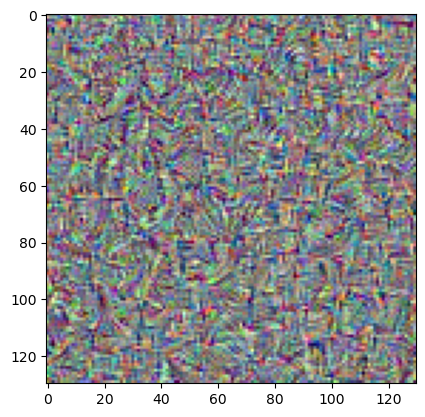

In [11]:
loss, filter_2 = visualize_filter(438)
plt.imshow(filter_2)  # convert from Tensor image

In [12]:
# Get 24 filters
img_width = 180
img_height = 180

all_imgs = []
for filter_index in range(250, 274):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)  # Assuming visualize_filter function is defined elsewhere
    all_imgs.append(img)

Processing filter 250
Processing filter 251
Processing filter 252
Processing filter 253
Processing filter 254
Processing filter 255
Processing filter 256
Processing filter 257
Processing filter 258
Processing filter 259
Processing filter 260
Processing filter 261
Processing filter 262
Processing filter 263
Processing filter 264
Processing filter 265
Processing filter 266
Processing filter 267
Processing filter 268
Processing filter 269
Processing filter 270
Processing filter 271
Processing filter 272
Processing filter 273


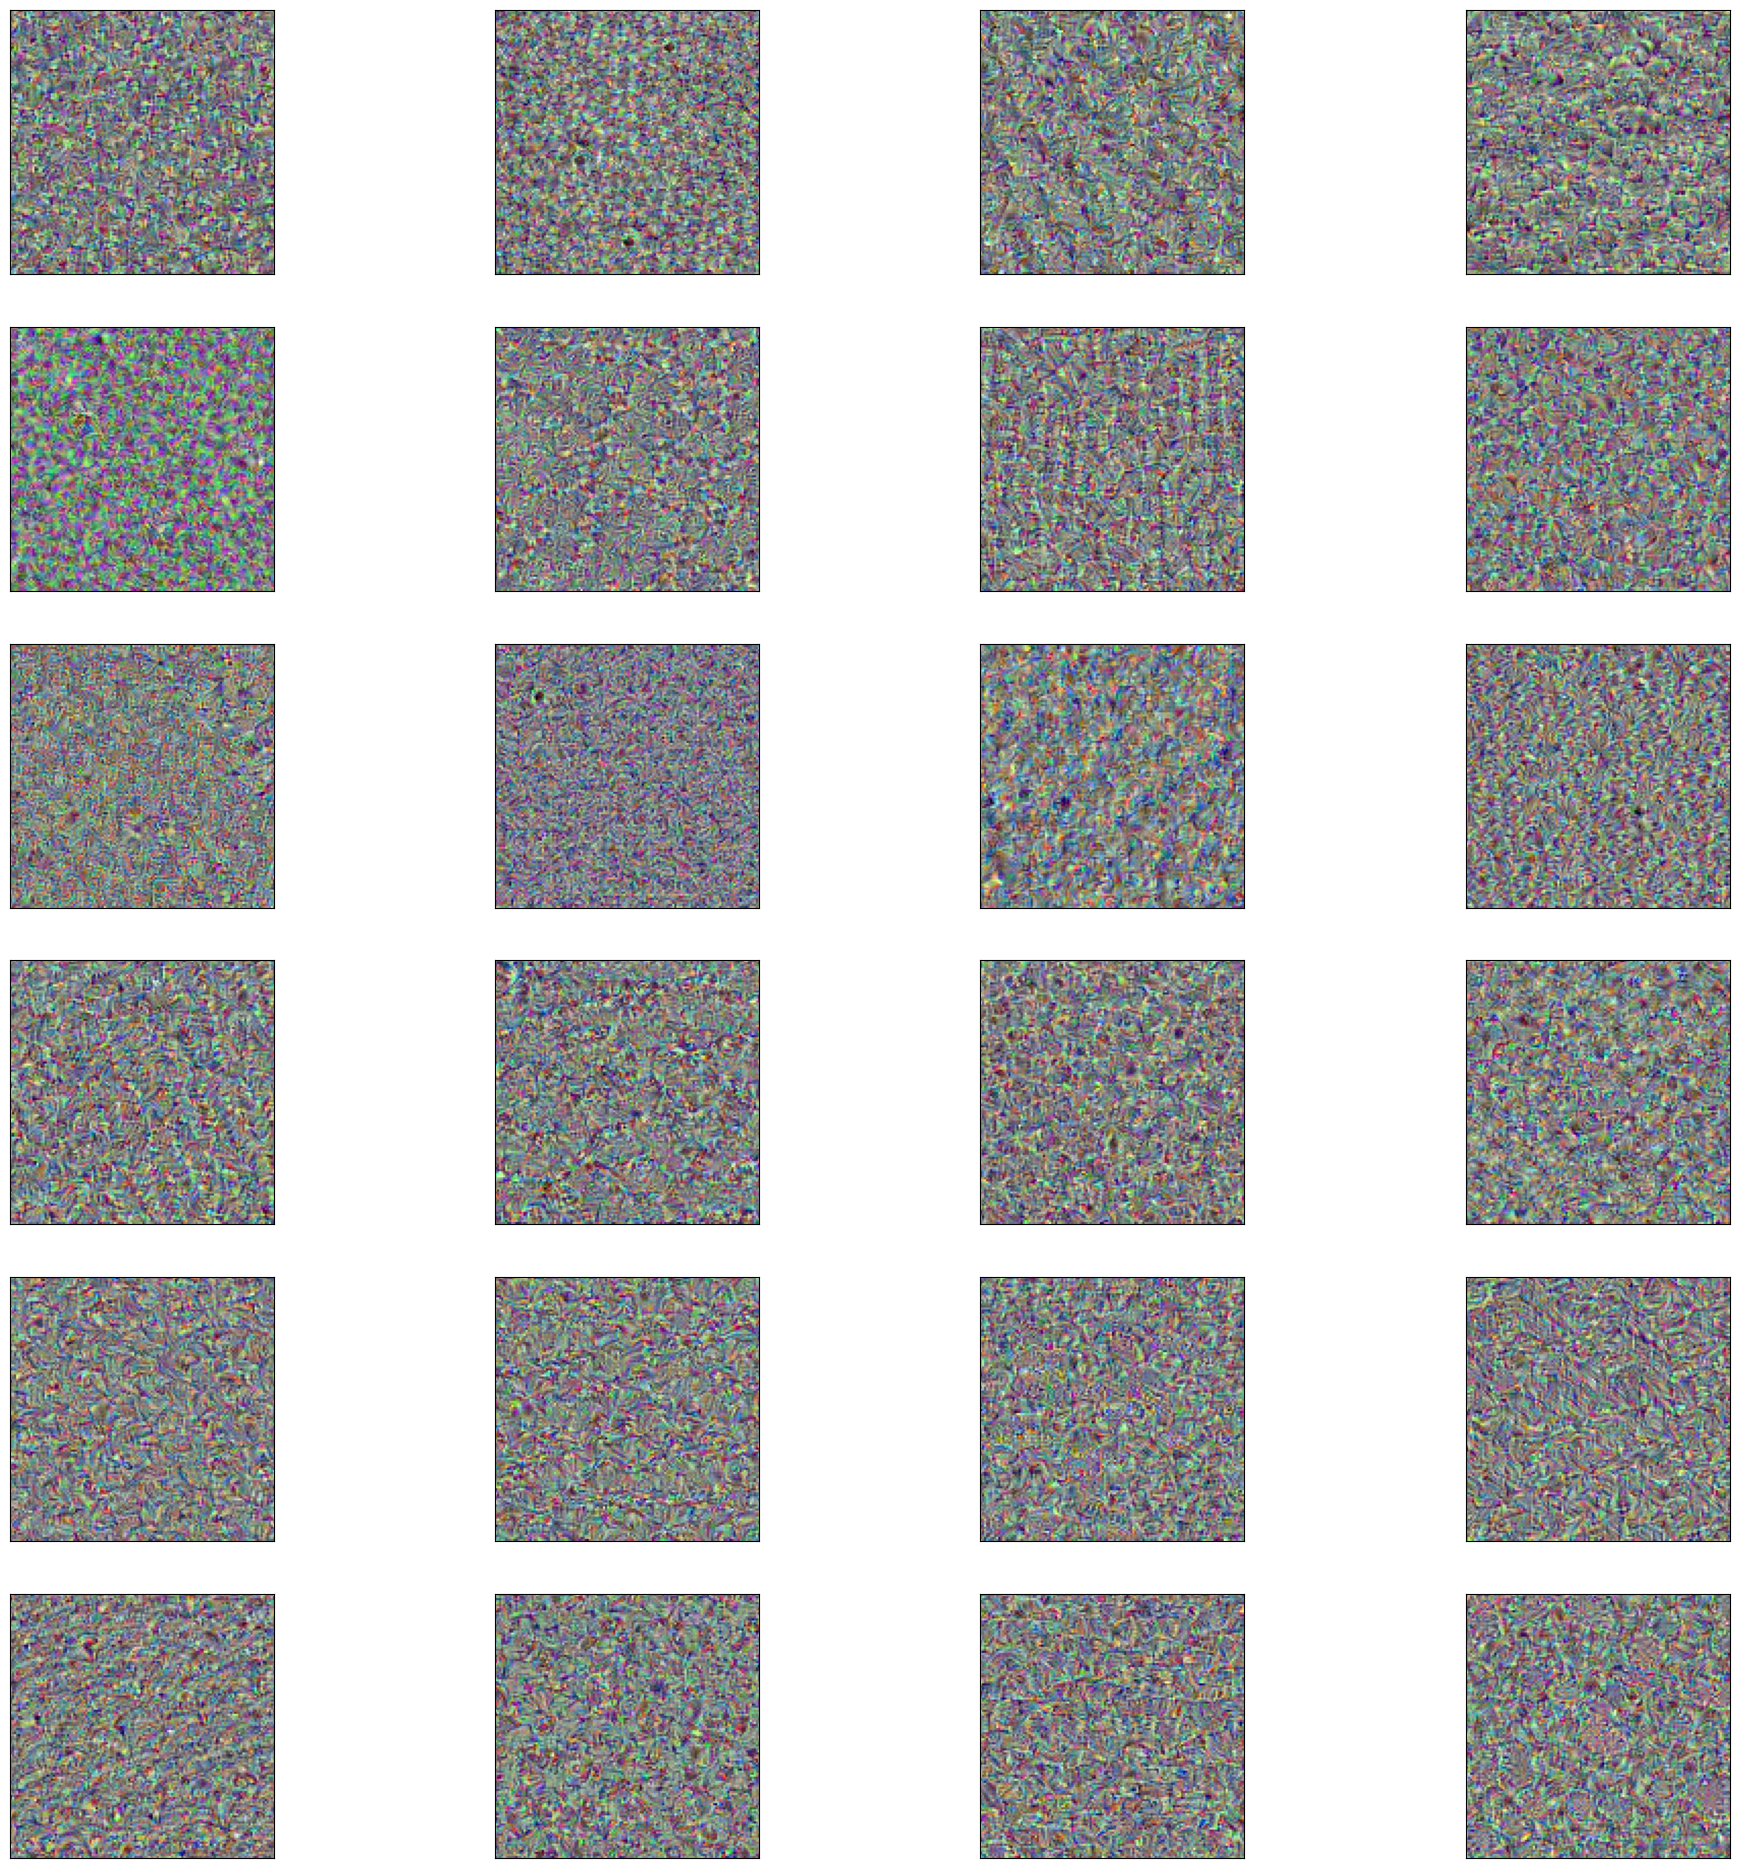

In [13]:
fig = plt.figure(figsize=[24, 24])
# display 24 images
for idx in np.arange(24):
    ax = fig.add_subplot(6, 64//16, idx+1, xticks=[], yticks=[])
    plt.imshow(all_imgs[idx])
plt.show()